## Import the necessary libraries


In [93]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

import seaborn as sns

## Read the training and test datasets

In [94]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

# Inspect the first few rows in the training dataset
df_train.head()

,UID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Target
0,1,S,45,11,39,1,C124,45,30,113043,45.5,0,56OGNNnQ,0,332,28.5000,2,0
1,2,S,74,35,36,2,NaN,14,99,28425,23.0,0,lpe6DkCG,0,734,13.0000,1,0
2,3,S,62,38,100,3,NaN,65,47,STON/O 2. 3101293,32.0,0,H7MHSxHc,0,383,7.9250,2,0
3,4,S,59,94,-3,3,NaN,17,26,350025,26.0,0,AFt8biyX,1,705,7.8542,1,0
4,5,S,26,72,33,3,NaN,45,17,347082,6.0,2,9O4X1MIW,4,814,31.2750,2,0


## Check missing data in the training dataset


In [95]:
df_train.isnull().sum()

,0
UID,0
Feature_1,2
Feature_2,0
Feature_3,0
Feature_4,0
Feature_5,0
Feature_6,553
Feature_7,0
Feature_8,0
Feature_9,0


#### Check the datatypes of the columns. We observe that Feature_1, Feature_6, Feature_9  and Feature_12 are categorical variables. As part of our feature selection, we will remove the unique identifier UID, Features 9 (freeform text) and 12 (freeform text) in our data pre-processing steps (besides a few other variables based on how strongly they are correlated to the target variable).

In [96]:
df_train.dtypes


,0
UID,int64
Feature_1,object
Feature_2,int64
Feature_3,int64
Feature_4,int64
Feature_5,int64
Feature_6,object
Feature_7,int64
Feature_8,int64
Feature_9,object


#### Print unique values for Feature 1

In [97]:
df_train['Feature_1'].unique()


array(['S', 'C', 'Q', nan], dtype=object)

#### Print unique values for Feature 6

In [98]:
df_train['Feature_6'].unique()

array(['C124', nan, 'B58 B60', 'B38', 'C52', 'C93', 'C45', 'B20',
       'B96 B98', 'C82', 'C78', 'C106', 'C22 C26', 'B57 B59 B63 B66',
       'B28', 'C104', 'F2', 'D11', 'C86', 'E38', 'A34', 'C91', 'C68',
       'F G73', 'E46', 'C92', 'E50', 'A32', 'G6', 'C128', 'E10', 'E44',
       'B41', 'B18', 'D35', 'E31', 'C2', 'C50', 'C103', 'B3', 'A10',
       'C49', 'C90', 'B77', 'C123', 'D', 'D36', 'E33', 'B5', 'A19', 'B37',
       'E58', 'C23 C25 C27', 'F33', 'C7', 'E67', 'E8', 'B22', 'B35',
       'C125', 'C65', 'C54', 'B80', 'B94', 'D26', 'E121', 'E24', 'D45',
       'B101', 'B51 B53 B55', 'D17', 'D46', 'E17', 'B4', 'C46', 'A23',
       'F4', 'C47', 'E101', 'C111', 'C101', 'B82 B84', 'C70', 'C32',
       'B102', 'D20', 'B71', 'A36', 'D9', 'B50', 'D33', 'A16', 'B19',
       'E12', 'C83', 'A26', 'F E69', 'A24', 'B73', 'C30', 'E40', 'D30',
       'B42', 'C99', 'C85', 'D37', 'T', 'F38', 'C118', 'B49', 'B79', 'D6',
       'F G63', 'A14', 'D49', 'C87', 'D56', 'C62 C64'], dtype=object)

### Utility function for feature engineering

In [99]:
# Perform Feature Engineering on the train and test datasets
def preprocess_data(df_train, df_test):

    # Merge the two datasets so we apply the same imputations, same transformation on both these datasets
    df = pd.concat([df_train, df_test], axis = 0)

    # Drop columns that are not contributing in a statistically meaningful way to the model (using the correlation to the
    # Target variable)
    columns_to_drop = ['UID', 'Feature_2', 'Feature_3',  'Feature_4', 'Feature_7', 'Feature_9', 'Feature_12']
    df = df.drop(columns=columns_to_drop, axis=1)

    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

    # Fill numeric missing values with mean values in the respective columns
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].mean())

    # We observe that Feature 1 has 3 distinct values (S, C, Q). Perform one hot encoding on this categorical feature
    df['Feature_1'] = df['Feature_1'].fillna('U')   # Fill nulls with the value 'U'
    df = pd.get_dummies(df, columns = ['Feature_1'], prefix = 'Feature_1')
    df = df.drop('Feature_1_U', axis = 1)

    # Feature 6 is a combination of an alphabet and a number. Create a secondary feature by extracting the prefix
    # out of Feature 6 (this reduces the unique values) and then perform one hot encoding on the new variable
    df['Feature_6'] = df['Feature_6'].fillna('U000') # Fill nulls with an arbitrary value
    df['Feature_6_Prefix'] = df['Feature_6'].str.extract(r'([a-zA-z]+)', expand = False)
    df = pd.get_dummies(df, columns = ['Feature_6_Prefix'], prefix = 'Feature_6')
    df = df.drop('Feature_6', axis = 1)
    df = df.drop('Feature_6_U', axis = 1)

    df_train = df[:len(df_train)]
    df_test = df[len(df_train):]

    df_test = df_test.drop('Target', axis = 1)

    return df_train, df_test

## Preprocess data and create the train test data split

In [100]:
df_test['Target'] = 0
processed_train, processed_test = preprocess_data(df_train, df_test)

X = processed_train.drop('Target', axis=1)
y = processed_train['Target']

print(X.head())

# Create train-validation split (in the ratio 80:20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

processed_test_scaled = scaler.transform(processed_test)

   Feature_5  Feature_8  Feature_10  Feature_11  Feature_13  Feature_14  \
0          1         30        45.5           0           0         332   
1          2         99        23.0           0           0         734   
2          3         47        32.0           0           0         383   
3          3         26        26.0           0           1         705   
4          3         17         6.0           2           4         814   

   Feature_15  Feature_16  Feature_1_C  Feature_1_Q  Feature_1_S  Feature_6_A  \
0     28.5000           2        False        False         True        False   
1     13.0000           1        False        False         True        False   
2      7.9250           2        False        False         True        False   
3      7.8542           1        False        False         True        False   
4     31.2750           2        False        False         True        False   

   Feature_6_B  Feature_6_C  Feature_6_D  Feature_6_E  Feature

## Verify the shapes of the training and validation datasets

In [101]:
print("Training set shape:", X_train_scaled.shape)
print("Validation set shape:", X_val_scaled.shape)

Training set shape: (569, 19)
Validation set shape: (143, 19)


### Feature selection.
##### Calculate how strongly each feature in the processed_train dataframe is correlated with the 'Target' column. This can help identify which features are most related to the target variable. Use this metric (over several iterations) to decide which features should be used to train the model and which feautures can be removed before preparing the model.






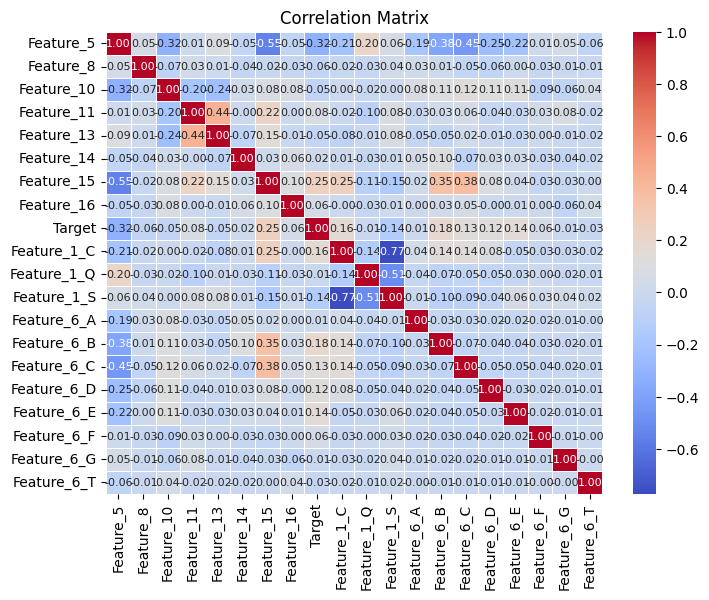

In [102]:
processed_train.corr()['Target']

# Compute the correlation matrix
corr_matrix = processed_train.corr()

# Show the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 8}, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Create an ML Model using XGBoost, apply the model to predict labels for the validation dataset and report key metrics (accuracy score, recision, recall, F1-score and the confusion metrics)


XGBoost Model Performance Metrics:
Accuracy: 0.7062937062937062
Precision: 0.6666666666666666
Recall: 0.5
F1-score: 0.5714285714285714
XGBoost Confusion Matrix:
[[73 14]
 [28 28]]


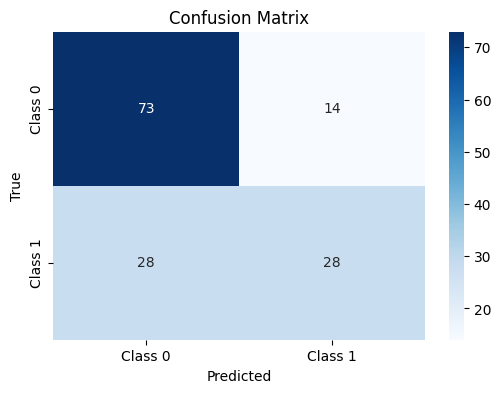

In [103]:
# XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train XGBoost
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)

# Calculate XGBoost metrics
accuracy = accuracy_score(y_val, xgb_pred)
precision = precision_score(y_val, xgb_pred)
recall = recall_score(y_val, xgb_pred)
f1 = f1_score(y_val, xgb_pred)
conf_matrix = confusion_matrix(y_val, xgb_pred)

print("XGBoost Model Performance Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\
XGBoost Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Apply the model to predict labels on the test dataset

In [104]:

y_pred_test = xgb_model.predict(processed_test_scaled)

### Create the submission file (Format: UID-Target).
###### This model achieved an accuracy of **0.76422** on the public leaderboard and **0.80357** on the private leaderboard (Team Name: TeamML)                            


In [105]:
# Create and save submission in a csv
submission_df = pd.DataFrame({
    'UID': df_test['UID'],
    'Target': y_pred_test
})

submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)